In [1]:
import sys
sys.path.append('/global/home/users/nathan_sandford/D-Payne')

import numpy as np
import matplotlib.pyplot as plt

import utils
import model_spectra as NN
import fitting

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# Check label recovery 

Best Fit Labels:
[0.00 -1.53 -1.50 -1.50 -1.46 -1.47 -1.47 -1.50 4107.08 0.54 9.86]
True Labels:
[0.00 -1.50 -1.50 -1.50 -1.50 -1.50 -1.50 -1.50 4100.00 0.50 10.00]


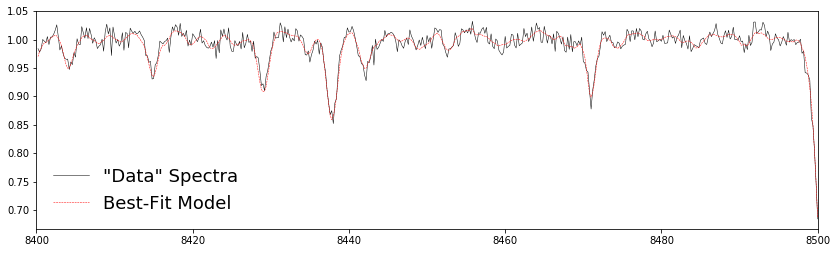

In [6]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# read in all individual neural networks we'll need. 
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Generate a spectrum from labels and NN
feh = -1.5
alphafe = 0.0
alpha = alphafe + feh
Teff = 4100
logg = 0.5
dv = 10
real_labels = np.array([alphafe, alpha, alpha, alpha, alpha, alpha, alpha,
                        feh, Teff, logg, dv])
real_spec = NN.get_spectrum_from_neural_net(labels=real_labels, NN_coeffs=NN_coeffs)
data_spec = real_spec + 0.01 * np.random.randn(len(real_spec))
spec_err = 0.01 * np.ones(len(wavelength))

# Apply Mask
kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
mask = utils.generate_mask_from_dict(**kirby_2008_stellar)
spec_err[mask] = 1e16

# Fit spectrum
popt, pcov, model_spec \
    = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = None, num_p0 = 1)

# zoom in on a small region of the spectrum so we can see what's going on.
lambda_min, lambda_max = 8400, 8500# for plotting 
plt.figure(figsize=(14, 4))
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = '"Data" Spectra')
plt.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = 'Best-Fit Model')
plt.xlim(lambda_min, lambda_max)
plt.legend(loc = 'best', frameon = False, fontsize = 18)

print('Best Fit Labels:')
print(popt)

print('True Labels:')
print(real_labels)

# Fitting Spectra from the Training Set

In [7]:
D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/synth_spectra/'
SpectraFile = 'convolved_synthetic_spectra_MIST.npz'
temp = np.load(SpectraDir + SpectraFile)
spectra = temp['spectra']
norm_spectra = temp['norm_spectra_approx']
labels = temp['labels']
temp.close()

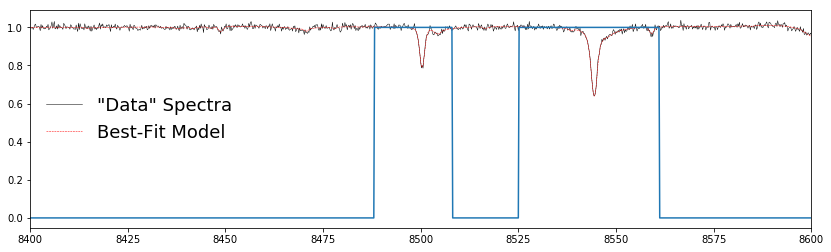

Best Fit Labels:
[0.45 -0.84 -0.82 -0.78 -0.91 -0.80 -0.82 -1.25 7007.10 4.44 0.20]
True Labels:
[0.40 -0.85 -0.85 -0.85 -0.85 -0.85 -0.85 -1.25 7046.95 4.45 0.00]


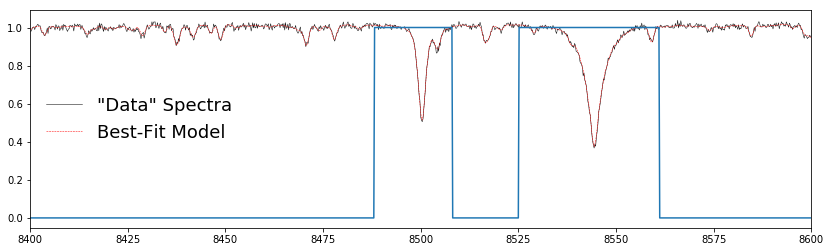

Best Fit Labels:
[0.21 -0.03 -0.08 -0.04 -0.06 -0.05 -0.03 -0.24 5430.70 2.70 0.22]
True Labels:
[0.20 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.25 5428.74 2.64 0.00]


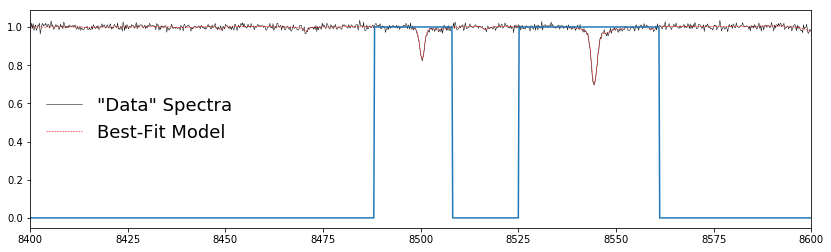

Best Fit Labels:
[-0.23 -1.49 -1.53 -1.53 -1.47 -1.48 -1.54 -1.24 6603.89 4.60 0.61]
True Labels:
[-0.20 -1.45 -1.45 -1.45 -1.45 -1.45 -1.45 -1.25 6624.00 4.58 0.00]


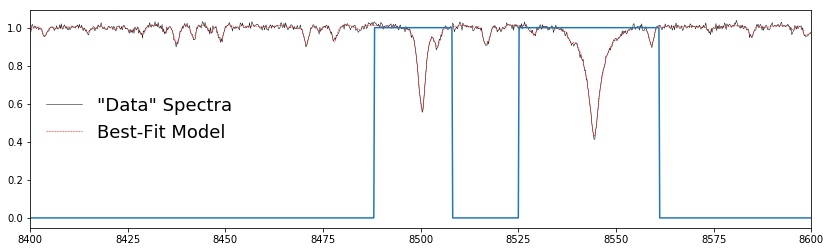

Best Fit Labels:
[0.01 -0.01 0.00 0.02 0.01 -0.01 -0.01 -0.01 5702.69 4.01 0.04]
True Labels:
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 5706.64 3.98 0.00]


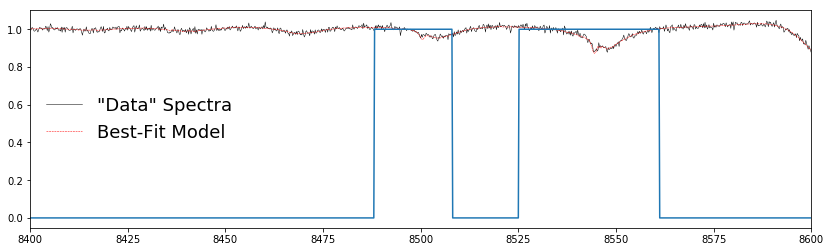

Best Fit Labels:
[0.08 -2.69 -2.69 -2.69 -2.74 -2.62 -2.54 -2.72 9030.91 4.19 -1.06]
True Labels:
[-0.40 -2.90 -2.90 -2.90 -2.90 -2.90 -2.90 -2.50 9072.86 4.19 0.00]


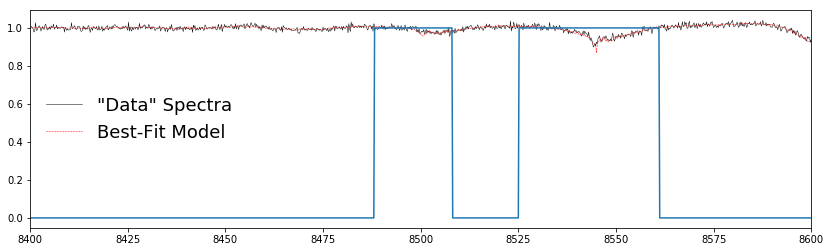

Best Fit Labels:
[-0.06 -2.78 -2.83 -2.83 -2.87 -2.86 -2.79 -2.76 9474.38 4.56 1.48]
True Labels:
[0.20 -2.80 -2.80 -2.80 -2.80 -2.80 -2.80 -3.00 9690.55 4.52 0.00]


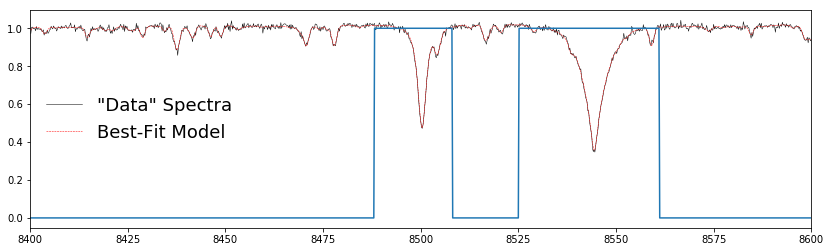

Best Fit Labels:
[0.79 0.28 0.30 0.28 0.27 0.30 0.35 -0.50 5433.85 2.55 0.08]
True Labels:
[0.80 0.30 0.30 0.30 0.30 0.30 0.30 -0.50 5437.85 2.50 0.00]


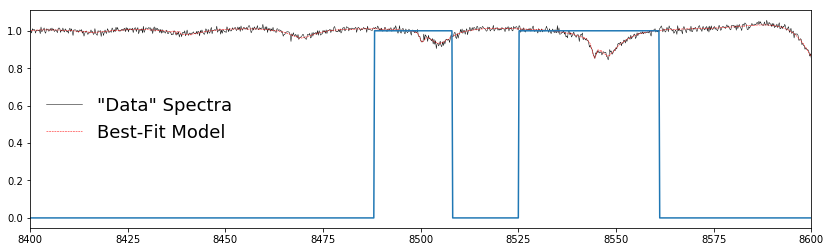

Best Fit Labels:
[0.13 -2.87 -2.85 -2.82 -2.85 -2.88 -2.81 -2.95 8215.74 3.92 0.59]
True Labels:
[0.20 -3.30 -3.30 -3.30 -3.30 -3.30 -3.30 -3.50 8171.09 3.88 0.00]


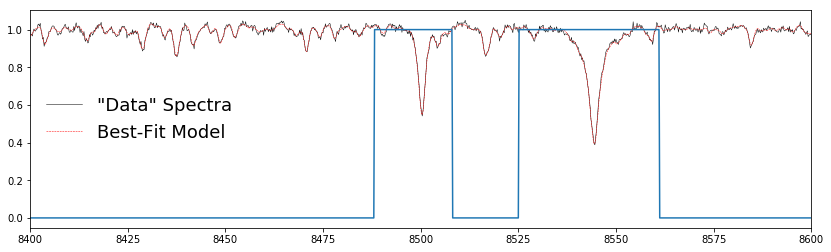

Best Fit Labels:
[-0.21 -0.23 -0.22 -0.23 -0.18 -0.19 -0.16 0.03 4927.17 3.09 0.16]
True Labels:
[-0.20 -0.20 -0.20 -0.20 -0.20 -0.20 -0.20 0.00 4943.91 3.17 0.00]


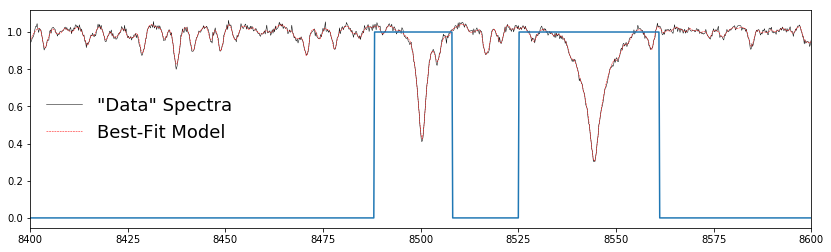

Best Fit Labels:
[0.20 0.44 0.44 0.45 0.43 0.46 0.41 0.26 5082.79 2.33 0.06]
True Labels:
[0.20 0.45 0.45 0.45 0.45 0.45 0.45 0.25 5093.61 2.27 0.00]


In [8]:
# Samples 10 spectra randomly from the training set
n = np.random.randint(0,len(norm_spectra),10)

for i, spec in enumerate(norm_spectra[n]):
    j = n[i]
    real_labels = np.append(labels[j],0.0)
    real_spec = spec
    data_spec = real_spec + 0.01 * np.random.randn(len(real_spec))
    spec_err = 0.01 * np.ones(len(real_spec))
    
    # Apply Mask
    kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
    mask = utils.generate_mask_from_dict(**kirby_2008_stellar)
    spec_err[mask] = 1e16
    
    # Restore NN
    NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

    # Fit spectrum
    popt, pcov, model_spec \
    = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = None, num_p0 = 1)

    # zoom in on a small region of the spectrum so we can see what's going on.
    lambda_min, lambda_max = 8400, 8600# for plotting 
    plt.figure(figsize=(14, 4))
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    plt.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = '"Data" Spectra')
    plt.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = 'Best-Fit Model')
    plt.plot(wavelength[m], spec_err[m]/1e16)
    plt.xlim(lambda_min, lambda_max)
    plt.legend(loc = 'best', frameon = False, fontsize = 18)
    plt.show()
    
    print('Best Fit Labels:')
    print(popt)
    
    print('True Labels:')
    print(real_labels)

# Fitting Real Spectra

In [9]:
wavelength = utils.load_wavelength_array()

D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/M15/'
SpectraFile = 'm15_Horne_ipynb.npz'
temp = np.load(SpectraDir + SpectraFile)
obj = temp['obj']
spec = temp['spec']
spectral_err = temp['spec_err']
dv = temp['dv']
RA = temp['RA']
Dec = temp['Dec']
temp.close()

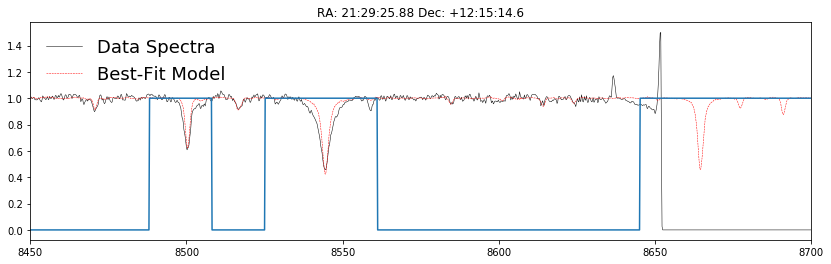

Best Fit Labels:
[0.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 4100.00 0.50 0.00]


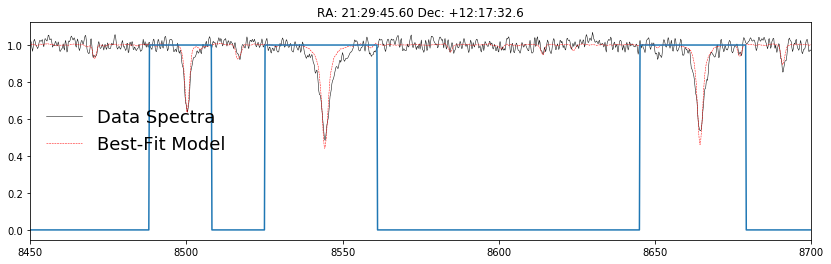

Best Fit Labels:
[0.03 -2.00 -2.03 -2.02 -1.95 -1.96 -2.03 -1.87 4266.26 0.65 -3.11]


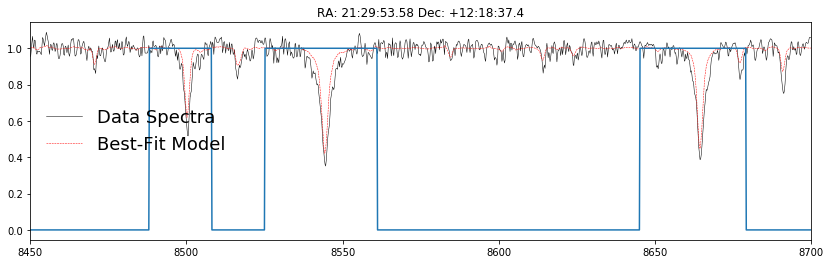

Best Fit Labels:
[-0.02 -2.02 -2.04 -1.96 -1.97 -1.95 -2.01 -1.88 4052.87 0.41 -3.80]


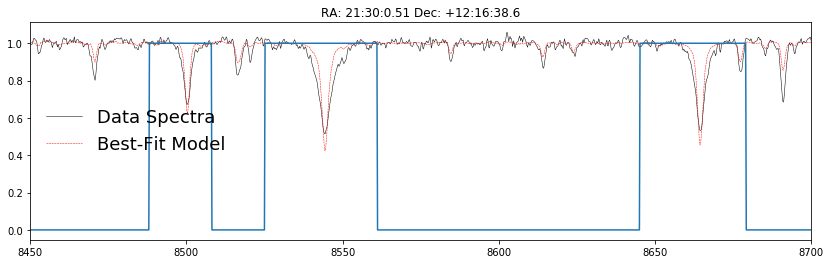

Best Fit Labels:
[-0.02 -1.99 -2.04 -2.04 -2.01 -1.99 -2.03 -1.96 3815.68 0.37 -1.21]


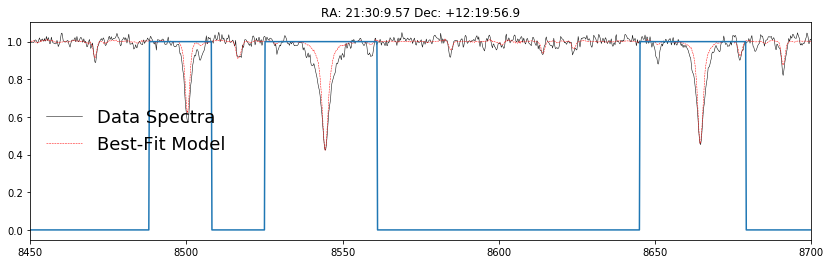

Best Fit Labels:
[0.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 4100.00 0.50 0.00]


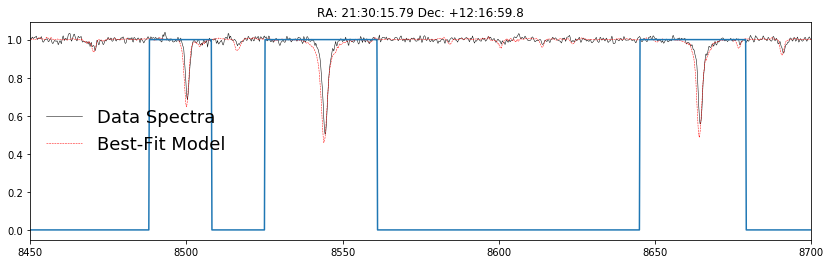

Best Fit Labels:
[-0.03 -1.98 -1.95 -1.99 -2.02 -1.96 -2.04 -1.89 4546.53 0.60 -11.13]


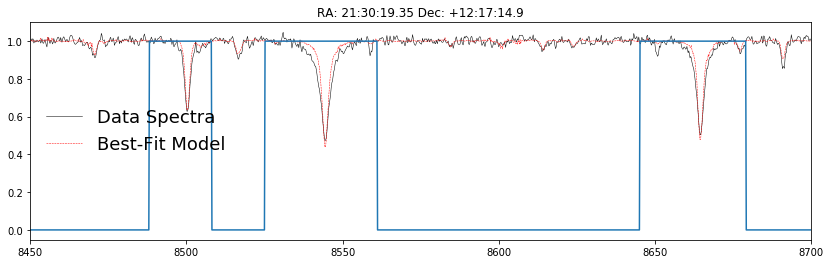

Best Fit Labels:
[-0.01 -2.03 -1.99 -2.02 -1.97 -2.03 -2.03 -2.06 4398.43 0.45 -0.08]


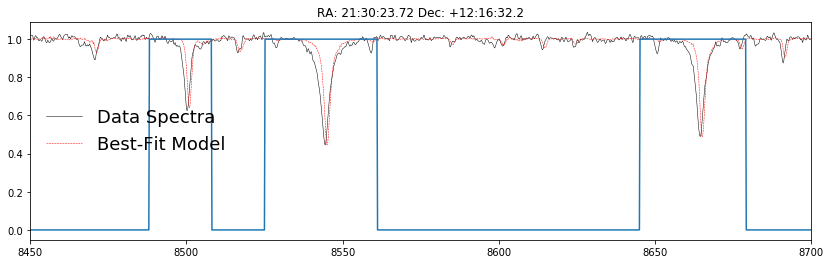

Best Fit Labels:
[0.01 -2.00 -2.03 -1.96 -2.02 -1.99 -1.96 -2.04 4408.25 0.61 21.82]


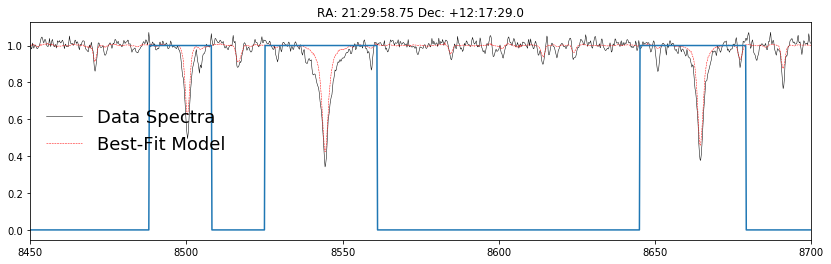

Best Fit Labels:
[0.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 4100.00 0.50 0.00]


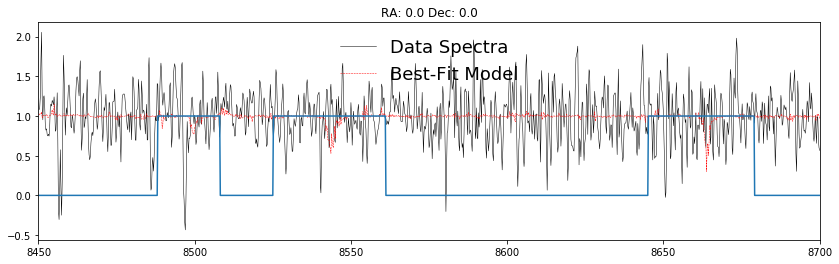

Best Fit Labels:
[1.48 -1.27 -4.64 -4.97 -5.00 -3.65 1.50 -2.47 4390.69 0.91 -26.62]


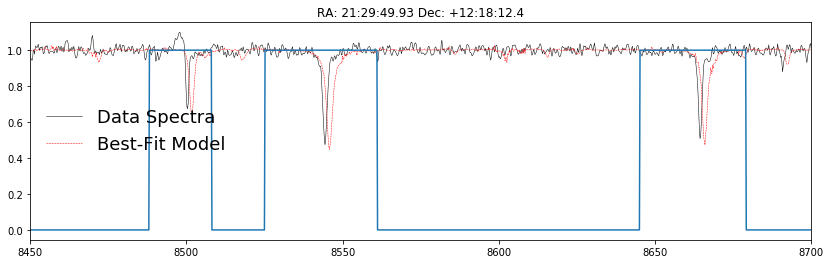

Best Fit Labels:
[-0.01 -1.98 -2.03 -2.02 -2.03 -2.02 -2.03 -2.03 4549.61 0.37 48.41]


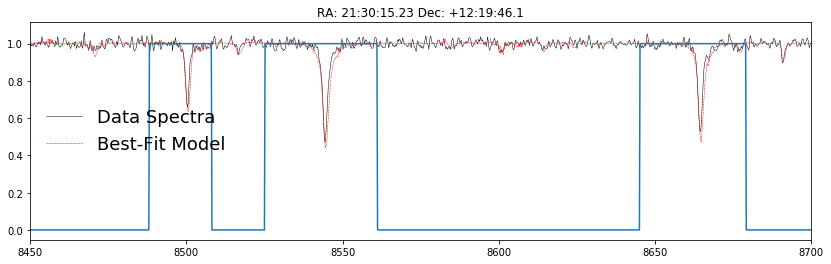

Best Fit Labels:
[-0.02 -2.04 -2.01 -1.99 -1.99 -2.04 -2.03 -2.02 4490.12 0.36 7.30]


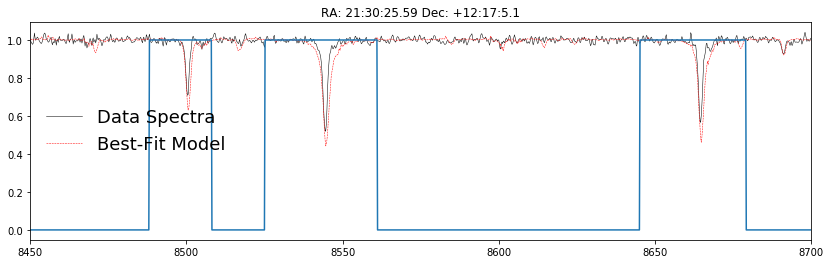

Best Fit Labels:
[0.04 -1.98 -1.95 -2.01 -1.97 -1.97 -2.04 -1.97 4519.19 0.30 10.18]


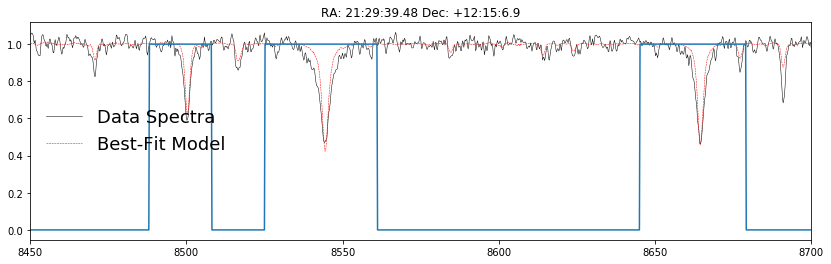

Best Fit Labels:
[0.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 4100.00 0.50 0.00]


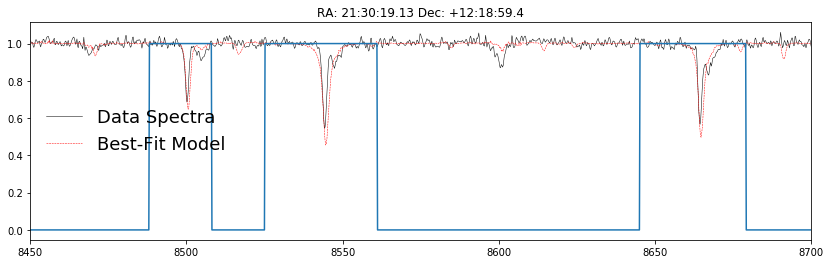

Best Fit Labels:
[0.04 -1.95 -2.04 -2.00 -2.02 -1.98 -1.96 -2.07 4517.35 0.61 8.17]


/global/home/users/nathan_sandford/D-Payne/model_spectra.py:21: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


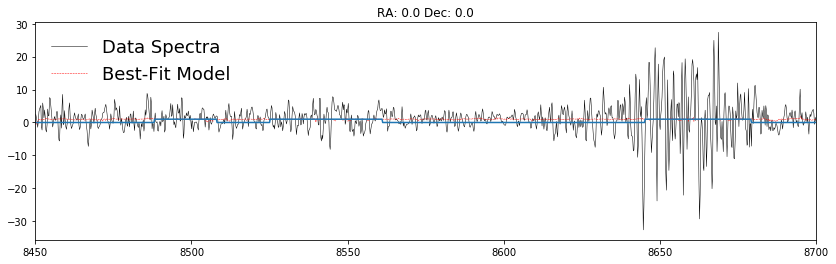

Best Fit Labels:
[-4.53 1.26 -2.01 1.09 -0.93 0.97 1.21 -3.77 3108.37 0.01 -165.90]


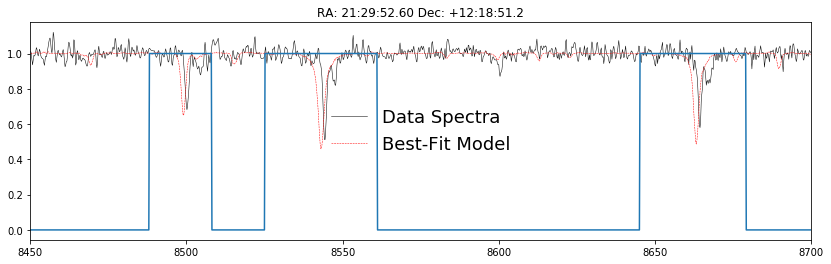

Best Fit Labels:
[0.01 -2.05 -1.96 -2.00 -1.97 -2.03 -2.02 -1.95 4476.27 0.64 -45.16]


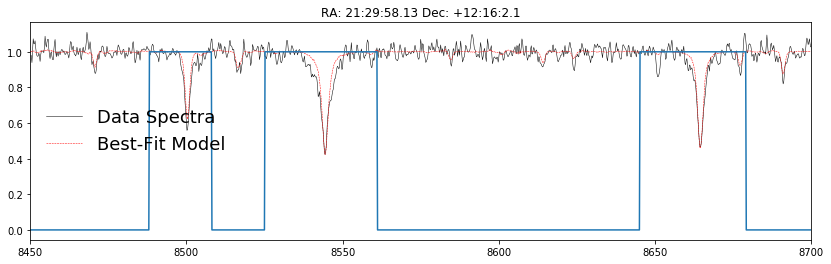

Best Fit Labels:
[0.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 4100.00 0.50 0.00]


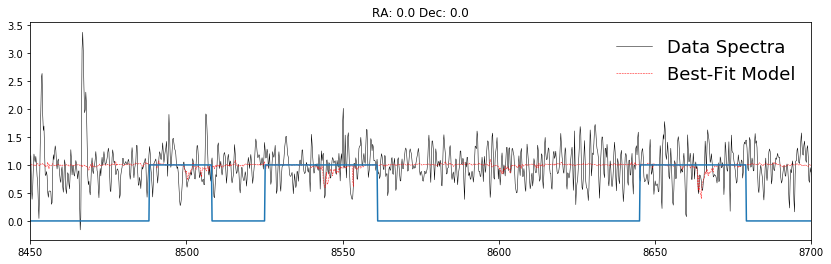

Best Fit Labels:
[-0.46 -2.89 -4.74 0.94 -2.65 -3.89 -4.96 -1.04 4919.16 0.03 4.11]


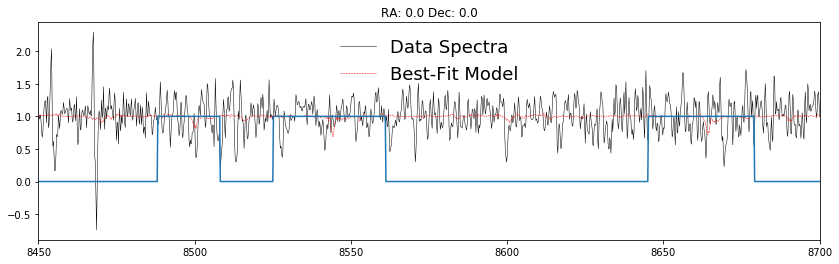

Best Fit Labels:
[-1.72 -1.03 -1.37 -4.93 -1.58 -3.48 -4.98 -2.05 4946.60 1.01 -10.88]


In [16]:
# Samples 10 spectra randomly from the training set
n = list(range(20))

for i in range(len(spec[n])):
    j = n[i]
    norm_spec = spec[j]
    spec_err = spectral_err[j]
    
    # Apply Mask
    kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
    mask = utils.generate_mask_from_dict(**kirby_2008_stellar)
    spec_err[mask] = 1e16
    
    # Restore NN
    NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')
    
    # Fit spectrum
    p0 = [0, -2, -2, -2, -2, -2, -2,
                        -2, 4100, 0.5, 0]
    popt, pcov, model_spec \
        = fitting.fit_normalized_spectrum_single_star_model(norm_spec = norm_spec,
                                                            spec_err = spec_err,
                                                            NN_coeffs = NN_coeffs,
                                                            p0 = p0, num_p0 = 10)

    # zoom in on a small region of the spectrum so we can see what's going on.
    lambda_min, lambda_max = 8450, 8700  # for plotting 
    plt.figure(figsize=(14, 4))
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    plt.title('RA: %s Dec: %s' % (RA[j],Dec[j]))
    plt.plot(wavelength[m], norm_spec[m], 'k', lw=0.5, label = 'Data Spectra')
    plt.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = 'Best-Fit Model')
    plt.plot(wavelength[m], spec_err[m]/1e16)
    plt.xlim(lambda_min, lambda_max)
    plt.legend(loc = 'best', frameon = False, fontsize = 18)
    plt.show()
    
    print('Best Fit Labels:')
    print(popt)
    
#    print('True Labels:')
#    print(real_labels)